In [25]:
from qiskit import QuantumCircuit, transpile
import numpy as np

##### First we define some helping functions

In [20]:
# flattening functions to go from 2d lattice point to qubit number in the way i texted in the group about
def lattice_to_qubit(i, j, N):
    if N%2 == 1:
        raise ValueError("N must be even")
    if j == 0:
        return i
    elif i%2 == 0:
        return N -1 + (N-1)*(N-1-i) + N - j
    else:
        return N -1 + (N-1)*(N-1-i) + j

# inverse transformation
def qubit_to_lattice(q, N):
    if N % 2 == 1:
        raise ValueError("N must be even")
    if q < N:
        return q, 0
    else:
        q -= N - 1
        i = N - 1 - (q - 1) // (N - 1)
        if i % 2 == 0:
            j = N - (q - 1) % (N - 1) - 1
        else:
            j = (q - 1) % (N - 1) + 1
        return i, j

# function to get neighbors of given point in qubit index
def get_neighbors(i,j,N):
    neighbors = [
        lattice_to_qubit(i-1,j,N),
        lattice_to_qubit(i+1,j,N),
        lattice_to_qubit(i,j-1,N),
        lattice_to_qubit(i,j+1,N)
    ]
    return neighbors

# implementing the W operator for XX and YY (for now)
# This does not work properly yet

def W(qc, N, t, M, g_matrix):
    for _ in range(M-1):
            for parity in [0, 1]:  # First even qubits, then odd qubits
                for i in range(1,N):
                    for j in range(1,N):
                        if (i + j) % 2 == parity:  # Checkerboard condition
                            neighbors = get_neighbors(i, j, N)
                            for neighbor in neighbors:
                                q1 = lattice_to_qubit(i, j, N)
                                q2 = neighbor
                                angle = g_matrix[q1, q2] * t / M
                                
                                qc.rxx(angle, q1, q2)
                                qc.ryy(angle, q1, q2)
    

#### Comments on this so far

We do a $N^2 +1$ qubit circuit, because we have the one control and a $N^2$ qubit hamiltonian, because each qubit models one spin site.
Then we apply the phases first in order.
There is a problem with the K-string: Since we have nearest neighbor terms and i flatten the NxN lattice to $N^2$ qubits with the formula i defined above. This only works for even values sidelength of the system we are trying to simulate though as there otherwise wont be a mapping to ensure all nearest neighbors are of different parity (i think).

Rn i am not sure if the order $K (W^{t/M})^M K$ is correct or if there are supposed to be some K's in between the trotter steps as well.

In [22]:



def XY_model_QETU(phi, N, t, M, g_matrix):
    # creating a quantum circuit with NxN qubits and one ancilla qubit
    qc = QuantumCircuit(N**2 + 1)
    
    for phase in phi:
        # applying the x rotation by the phase to the ancilla qubit
        qc.rx(phase, 0)

        # applying the controlled K string of pauli operators
        for i in range(int(np.floor(N**2/2))): 
            qc.cz(0, 2*i+2)
        qc.barrier()
        
        # now applying the W matrix (only for the XX + YY part of the Hamiltonian)
        # I tried to parrallelize som of this to reduce depth, but it is essentially just
        # taking the nearest neighbor coupling terms for each i,j
        W(qc, N, t, M, g_matrix)
        
        qc.barrier()
        
        # applying the k-string again
        for i in range(int(np.floor(N**2/2))):
            qc.cz(0, 2*i+2)
        
        
    #taking the phases in reverse order to get the symmetry right
    for phase in phi[::-1]:
        # applying the x rotation by the phase to the ancilla qubit
        qc.rx(phase, 0)

        # applying the K-string again
        for i in range(int(np.floor(N**2/2))): # we have a problem because we no longer have a 1d string, this doesnt work like this
            qc.cz(0, 2*i+2)
        
        qc.barrier()

        W(qc, N, t, M, g_matrix)

        qc.barrier()
        
        # applying the k-string again
        for i in range(int(np.floor(N**2/2))):
            qc.cz(0, 2*i+2)

    return qc


In [24]:

N = 4
t = 1
M = 3
phi = [np.pi/2,0,0,0]
g_matrix = np.random.rand(N**2, N**2)
qc = XY_model_QETU(phi, N, t, M, g_matrix)
qc.draw('mpl')

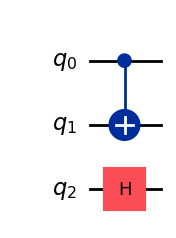

In [65]:
qc = QuantumCircuit(3)
qc.cx(0,1)
qc.h(2)
qc.draw('mpl')